# Chat Bot Evaluation as Multi-agent Simulation


When building a chat bot, such as a customer support assistant, it can be hard to properly evaluate your bot's performance. 

It's time-consuming to have to manually interact with it intensively for each code change.

One way to make the evaluation process easier and more reproducible is to **simulate** a **user** **interaction**.

With LangGraph, it's easy to set this up. Below is an example of how to create a **"virtual user"** to simulate a conversation.

The overall simulation looks something like this:

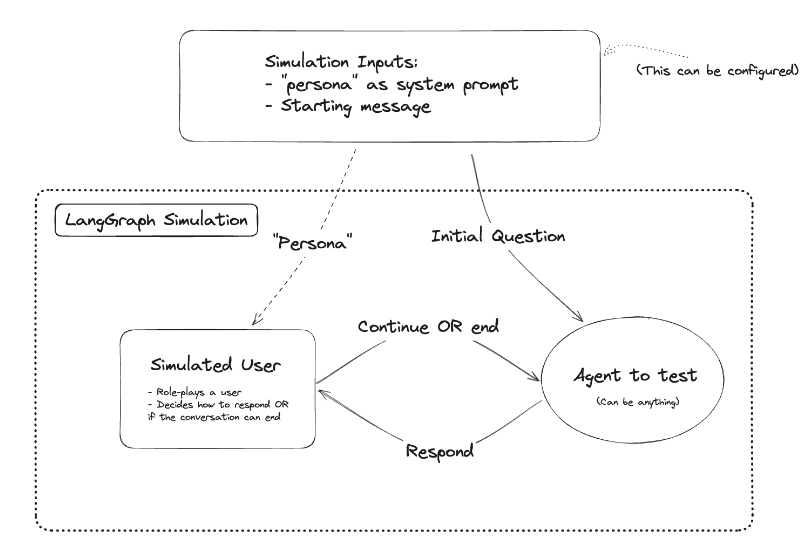

In [ ]:
from dotenv import load_dotenv
import os
load_dotenv()
from langchain_openai import ChatOpenAI

os.environ["LANGCHAIN_API_KEY"]=os.environ.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="Agent-Based-ChatBot-Evaluation"
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")


### 1. Define Chat Bot
Let's define our chat bot. 

For this notebook, we assume the bot's API accepts a list of messages and responds with a message. 

If you want to update this, all you'll have to change is this section and the "get_messages_for_agent" function in the simulator below.

The implementation within my_chat_bot is configurable and can even be run on another system (e.g., if your system isn't running in python).

In [18]:
from typing import List

import openai


# This is flexible, but you can define your agent here, or call your agent API here.
def my_chat_bot(messages: List[dict]) -> dict:
    system_message = {
        "role": "system",
        "content": "You are a customer support agent for an airline.",
    }
    messages = [system_message] + messages
    completion = openai.chat.completions.create(
        messages=messages, model="gpt-4o-mini"
    )
    return completion.choices[0].message.model_dump()

In [19]:
my_chat_bot([{"role": "user", "content": "hi!"}])

{'content': 'Hello! How can I assist you today?',
 'role': 'assistant',
 'function_call': None,
 'tool_calls': None,
 'refusal': None}

### 2. Define Simulated User
We're now going to define the simulated user. This can be anything we want, but we're going to build it as a LangChain bot.

In [20]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

system_prompt_template = """You are a customer of an airline company. \
You are interacting with a user who is a customer support person. \

{instructions}

When you are finished with the conversation, respond with a single word 'FINISHED'"""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt_template),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
instructions = """Your name is Harrison. You are trying to get a refund for the trip you took to Alaska. \
You want them to give you ALL the money back. \
This trip happened 5 years ago."""

prompt = prompt.partial(name="Harrison", instructions=instructions)

model = ChatOpenAI()

simulated_user = prompt | model

In [21]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="Hi! How can I help you?")]
simulated_user.invoke({"messages": messages})

AIMessage(content='Hi, I would like to inquire about getting a refund for a trip I took to Alaska 5 years ago. I believe I am entitled to a full refund for that trip.', response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 98, 'total_tokens': 134}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-4a230ff2-125c-4464-a41f-37b115ee51a5-0', usage_metadata={'input_tokens': 98, 'output_tokens': 36, 'total_tokens': 134})

### 3. Define the Agent Simulation
The code below creates a LangGraph workflow to run the simulation. 

The main components are:

1. The two nodes: one for the simulated user, the other for the chat bot.
2. The graph itself, with a conditional stopping criterion.

Read the comments in the code below for more information.

### Nodes

First, we define the nodes in the graph. These should take in a list of messages and return a list of messages to ADD to the state. These will be thing wrappers around the chat bot and simulated user we have above.

**Note**: one tricky thing here is which messages are which. 

Because both the chat bot AND our simulated user are both LLMs, both of them will resond with AI messages. 
Our state will be a list of alternating Human and AI messages. 
This means that for one of the nodes, there will need to be some logic that flips the AI and human roles. 
In this example, we will assume that HumanMessages are messages from the simulated user. This means that we need some logic in the simulated user node to swap AI and Human messages.

First, let's define the chat bot node

In [22]:
from langchain_community.adapters.openai import convert_message_to_dict
from langchain_core.messages import AIMessage


def chat_bot_node(messages):
    # Convert from LangChain format to the OpenAI format, which our chatbot function expects.
    messages = [convert_message_to_dict(m) for m in messages]
    # Call the chat bot
    chat_bot_response = my_chat_bot(messages)
    # Respond with an AI Message
    return AIMessage(content=chat_bot_response["content"])


Next, let's define the node for our simulated user. This will involve a little logic to swap the roles of the messages.

In [23]:
def _swap_roles(messages):
    new_messages = []
    for m in messages:
        if isinstance(m, AIMessage):
            new_messages.append(HumanMessage(content=m.content))
        else:
            new_messages.append(AIMessage(content=m.content))
    return new_messages


def simulated_user_node(messages):
    # Swap roles of messages
    new_messages = _swap_roles(messages)
    # Call the simulated user
    response = simulated_user.invoke({"messages": new_messages})
    # This response is an AI message - we need to flip this to be a human message
    return HumanMessage(content=response.content)

# Edges

We now need to define the logic for the edges. 

The main logic occurs after the simulated user goes, and it should lead to one of two outcomes:

* Either we continue and call the customer support bot
* Or we finish and the conversation is over
  
So what is the logic for the conversation being over? We will define that as either the Human chatbot responds with FINISHED (see the system prompt) OR the conversation is more than 6 messages long (this is an arbitrary number just to keep this example short).

In [24]:
def should_continue(messages):
    if len(messages) > 6:
        return "end"
    elif messages[-1].content == "FINISHED":
        return "end"
    else:
        return "continue"

# Graph

We can now define the graph that sets up the simulation!

In [25]:
from langgraph.graph import END, MessageGraph, START

graph_builder = MessageGraph()
graph_builder.add_node("user", simulated_user_node)
graph_builder.add_node("chat_bot", chat_bot_node)
# Every response from  your chat bot will automatically go to the
# simulated user
graph_builder.add_edge("chat_bot", "user")
graph_builder.add_conditional_edges(
    "user",
    should_continue,
    # If the finish criteria are met, we will stop the simulation,
    # otherwise, the virtual user's message will be sent to your chat bot
    {
        "end": END,
        "continue": "chat_bot",
    },
)
# The input will first go to your chat bot
graph_builder.add_edge(START, "chat_bot")
simulation = graph_builder.compile()

### 4. Run Simulation
Now we can evaluate our chat bot! We can invoke it with empty messages (this will simulate letting the chat bot start the initial conversation)

In [26]:
for chunk in simulation.stream([]):
    # Print out all events aside from the final end chunk
    if END not in chunk:
        print(chunk)
        print("----")

{'chat_bot': AIMessage(content='How can I assist you today?')}
----
{'user': HumanMessage(content='Hello, I would like to inquire about getting a refund for a trip I took with your airline to Alaska five years ago. I believe I am entitled to a full refund for that trip.', id='83c527c3-5d36-48ae-b7bc-af96e19669f9')}
----
{'chat_bot': AIMessage(content='I understand your concern regarding a refund for your trip to Alaska. However, our refund policy generally allows for claims to be filed within a specific timeframe, typically within a few months after the flight. Since your trip was five years ago, it is unlikely that a refund can be processed at this time. \n\nIf you believe there were exceptional circumstances that warrant a review of your situation, I recommend providing any relevant details, and I can guide you on how to submit your request for further consideration.')}
----
{'user': HumanMessage(content='I appreciate your response. I understand the standard policy, but I believe my 